In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('clean_data.csv')
data.head()

,Unnamed: 0,Client_Name,Client_Description,Revenue,Expenses,Total_Assets,Total_Liabilities,Operating_Cash_Flow,Investments,Debt,Industry,Profit,Equity
0,0,Quantum Systems,Operations in retail,211193.550,1101594.02,4335149.100,1859964.43,794019.90,1605060.44,1973249.540,Healthcare,-890400.470,2475184.670
1,1,Future Group,Operations in finance,1409138.240,1706054.21,3065987.340,3051435.56,1580695.66,320735.51,1479129.070,Healthcare,-296915.970,14551.780
2,2,Green Group,Operations in technology,1565942.170,2050874.25,4472324.110,4249891.27,740335.51,660598.74,2832553.670,Retail,-484932.080,222432.840
3,3,Zenith International,Operations in finance,4072945.710,2451948.79,7311059.538,934413.24,1260431.19,2448670.42,3499959.580,Finance,1620996.920,6376646.298
4,4,Zenith International,Operations in retail,1951368.162,2300823.95,1337366.200,2378513.94,695055.49,939971.85,2916427.966,Retail,-349455.788,-1041147.740


In [3]:
data.drop(['Unnamed: 0'], axis = 1,inplace = True)

In [4]:
data.head()

,Client_Name,Client_Description,Revenue,Expenses,Total_Assets,Total_Liabilities,Operating_Cash_Flow,Investments,Debt,Industry,Profit,Equity
0,Quantum Systems,Operations in retail,211193.550,1101594.02,4335149.100,1859964.43,794019.90,1605060.44,1973249.540,Healthcare,-890400.470,2475184.670
1,Future Group,Operations in finance,1409138.240,1706054.21,3065987.340,3051435.56,1580695.66,320735.51,1479129.070,Healthcare,-296915.970,14551.780
2,Green Group,Operations in technology,1565942.170,2050874.25,4472324.110,4249891.27,740335.51,660598.74,2832553.670,Retail,-484932.080,222432.840
3,Zenith International,Operations in finance,4072945.710,2451948.79,7311059.538,934413.24,1260431.19,2448670.42,3499959.580,Finance,1620996.920,6376646.298
4,Zenith International,Operations in retail,1951368.162,2300823.95,1337366.200,2378513.94,695055.49,939971.85,2916427.966,Retail,-349455.788,-1041147.740


In [5]:
numerical_columns = ['Revenue', 'Expenses', 'Investments', 'Debt', 'Equity', 'Profit', 'Total_Assets', 'Total_Liabilities', 'Operating_Cash_Flow']
data = (data[numerical_columns] - data[numerical_columns].min()) / (data[numerical_columns].max() - data[numerical_columns].min())

In [6]:
def build_generator(latent_dim, output_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(output_dim, activation='sigmoid'))
    return model

In [7]:
def build_discriminator(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [8]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [9]:
latent_dim = 100  # Adjust as needed
output_dim = len(numerical_columns)
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
epochs = 10000  # Adjust as needed
batch_size = 64

for epoch in range(epochs):
    # Select a random batch of real data
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data = data.iloc[idx].values

    # Generate synthetic data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_data = generator.predict(noise)

    # Labels for real and generated data
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)

    # Train discriminator on generated data
    d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)

    # Overall discriminator loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

2/2 [==============================] - 0s 0s/step


Epoch 0, D Loss: 0.7090619206428528, G Loss: 0.5604831576347351
2/2 [==============================] - 0s 0s/step
Epoch 100, D Loss: 0.6572647094726562, G Loss: 0.719448983669281
2/2 [==============================] - 0s 1ms/step
Epoch 200, D Loss: 0.6446896195411682, G Loss: 0.8402186036109924
2/2 [==============================] - 0s 0s/step
Epoch 300, D Loss: 0.5036696642637253, G Loss: 1.1124610900878906
2/2 [==============================] - 0s 0s/step
Epoch 400, D Loss: 0.6987473368644714, G Loss: 0.784869909286499
2/2 [==============================] - 0s 0s/step
Epoch 500, D Loss: 0.7692756652832031, G Loss: 0.7809511423110962
2/2 [==============================] - 0s 0s/step
Epoch 600, D Loss: 0.5829014778137207, G Loss: 0.9304996728897095
2/2 [==============================] - 0s 0s/step
Epoch 700, D Loss: 0.6871484816074371, G Loss: 0.7043842673301697
2/2 [==============================] - 0s 10ms/step
Epoch 800, D Loss: 0.

In [11]:
num_samples = 10000  # Adjust as needed
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_data = generator.predict(noise)

313/313 [==============================] - 0s 930us/step


In [12]:
generated_data = generated_data * (data[numerical_columns].max().values - data[numerical_columns].min().values) + data[numerical_columns].min().values

In [13]:
generated_df = pd.DataFrame(generated_data, columns=numerical_columns)

In [14]:
generated_df

,Revenue,Expenses,Investments,Debt,Equity,Profit,Total_Assets,Total_Liabilities,Operating_Cash_Flow
0,0.125838,0.693034,0.860967,0.744094,0.485282,0.364280,0.268608,0.437885,0.374571
1,0.076224,0.773465,0.490873,0.850853,0.650328,0.301910,0.717718,0.789624,0.756955
2,0.140102,0.872113,0.653291,0.813409,0.608759,0.331151,0.609130,0.692961,0.152817
3,0.357070,0.950734,0.712696,0.879145,0.498412,0.507152,0.375152,0.735219,0.008667
4,0.239585,0.778764,0.898646,0.414337,0.637302,0.437014,0.571536,0.513037,0.088215
...,...,...,...,...,...,...,...,...,...
9995,0.249679,0.812969,0.477560,0.808856,0.473241,0.418861,0.440443,0.683384,0.587147
9996,0.375587,0.749080,0.543730,0.303787,0.484942,0.497662,0.494022,0.789670,0.209405
9997,0.119404,0.820236,0.761576,0.830449,0.583048,0.352573,0.591756,0.762028,0.423843
9998,0.193502,0.848225,0.836673,0.715221,0.446667,0.480083,0.261128,0.736533,0.176709


In [15]:
kl_divergence = {}
for column in numerical_columns:
    real_distribution = data[column].values
    generated_distribution = generated_df[column].values

    # Clip values to avoid issues with log(0)
    real_distribution = np.clip(real_distribution, 1e-10, None)
    generated_distribution = np.clip(generated_distribution, 1e-10, None)

    kl_divergence[column] = entropy(real_distribution, generated_distribution)

In [16]:
for column, divergence in kl_divergence.items():
    print(f"KL Divergence for {column}: {divergence}")

KL Divergence for Revenue: 0.3692797212633626
KL Divergence for Expenses: 0.18535636628132793
KL Divergence for Investments: 0.20198718755013423
KL Divergence for Debt: 0.21511779268736353
KL Divergence for Equity: 0.11191142397946256
KL Divergence for Profit: 0.12423120154118553
KL Divergence for Total_Assets: 0.249406771061852
KL Divergence for Total_Liabilities: 0.19645484665286683
KL Divergence for Operating_Cash_Flow: 0.45849678445841435


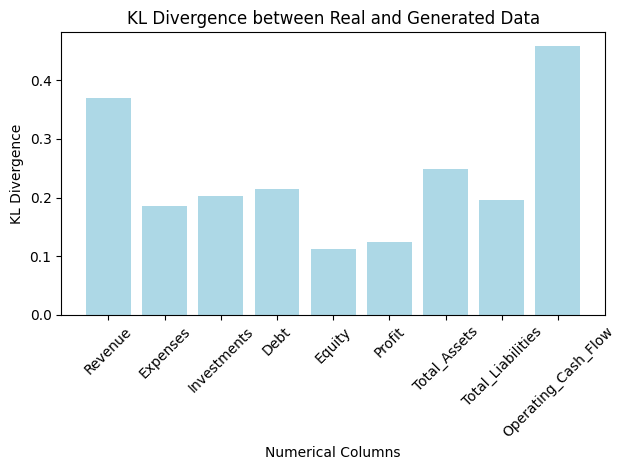

In [17]:
columns = list(kl_divergence.keys())
divergence_values = list(kl_divergence.values())

plt.bar(columns, divergence_values, color='lightblue')
plt.xlabel('Numerical Columns')
plt.ylabel('KL Divergence')
plt.title('KL Divergence between Real and Generated Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()